In [9]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
#device = 'mps'
device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

In [2]:
def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

In [3]:
# Data distribution
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


In [4]:
class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)


In [5]:

score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

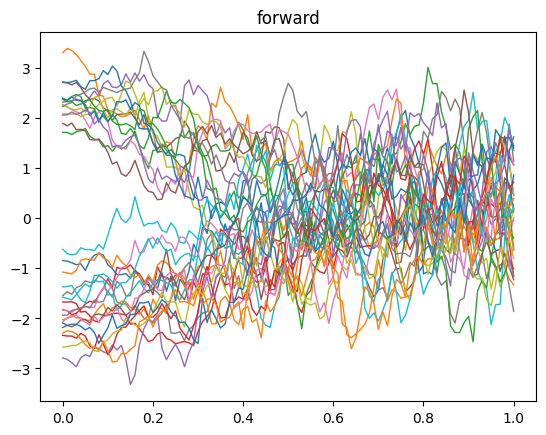

In [6]:
x_data_test = data_dist.sample([num_paths])
x_noise_test, traj_forward_test = diffusion.forward_sample(x_data_test)

xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_forward_test:
    plt.plot(xxx, line, linewidth=1.0)
    plt.title('forward')

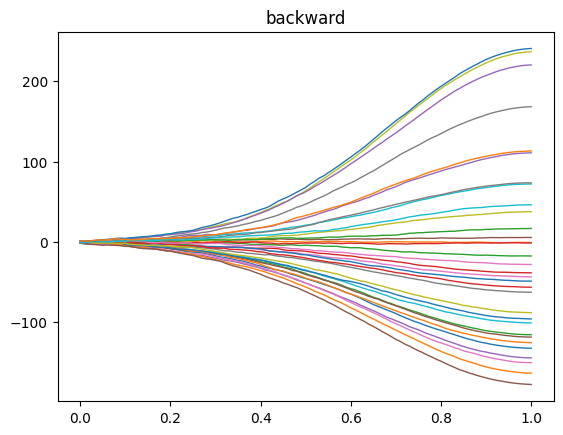

In [7]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)
xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

In [10]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

pcf = PCF_with_empirical_measure(16, 10, 1, add_time=True)
pcf = pcf.to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-3)

Train the network with PCF distance and reconstrucion loss. Time dimension has been added the PCF network.

I am using min-max way to train both PCF network and score network.

In [5]:
num_epochs = 1000
for i in range(num_epochs):
    if 500 <i <=800:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=5e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-4)
    elif i>800:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
        
    
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(torch.cat((torch.randn([num_paths, 1]).to(device), traj_forward[:,-1].unsqueeze(1)),0), score_net)
        traj_forward_flip = torch.fliplr(traj_forward)
        traj_forward_flip_cat = torch.cat((traj_forward_flip.view([-1, total_steps+1, 1]),traj_forward_flip.view([-1, total_steps+1, 1])),0)

    pcf.train()
    D_loss = -pcf.distance_measure(traj_forward_flip_cat, traj_back.view([-1, total_steps+1, 1]), Lambda=1.0)

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
   
    # train the score network to minmise the distance between the real data and the generated data
    x_gen, traj_back = diffusion.backward_sample(torch.cat((torch.randn([num_paths, 1]).to(device), traj_forward[:,-1].unsqueeze(1)),0).to(device), score_net)
    x_gen1, traj_back1 = x_gen[num_paths:], traj_back[num_paths:]
    traj_back_flip1 = torch.fliplr(traj_back1)
    pcf.eval()
    
    G_loss =  pcf.distance_measure(traj_forward_flip_cat, traj_back.view([-1, total_steps+1, 1]), Lambda=1.0) + \
        0.5*torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_forward.shape[0], -1), dim=(0,1))

    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()

    print(i, D_loss.item() , G_loss.item())

0 -2.423473834991455 6271.28271484375
1 -2.2835094928741455 102.76637268066406
2 -1.3802969455718994 15.63451099395752
3 -1.64984130859375 7.987453460693359
4 -1.5543614625930786 4.808877944946289
5 -1.615252137184143 4.272960662841797
6 -2.1287734508514404 3.8895468711853027
7 -2.348158359527588 4.190672874450684
8 -3.0191264152526855 4.650261402130127
9 -3.271824359893799 4.332761764526367
10 -3.0797224044799805 4.921642780303955
11 -3.307023286819458 4.76644229888916
12 -3.8914690017700195 5.6236395835876465
13 -4.360930919647217 5.7673468589782715
14 -3.6608126163482666 5.309208869934082
15 -3.282071352005005 5.255958080291748
16 -5.087416172027588 5.371118545532227
17 -3.7133278846740723 5.9203596115112305
18 -4.793025016784668 5.496155738830566
19 -4.604830741882324 5.938668727874756
20 -5.106809616088867 5.890870094299316
21 -4.853236675262451 6.7403998374938965
22 -4.259499549865723 6.297280788421631
23 -4.306490421295166 5.1942267417907715
24 -4.388273239135742 5.0279664993286

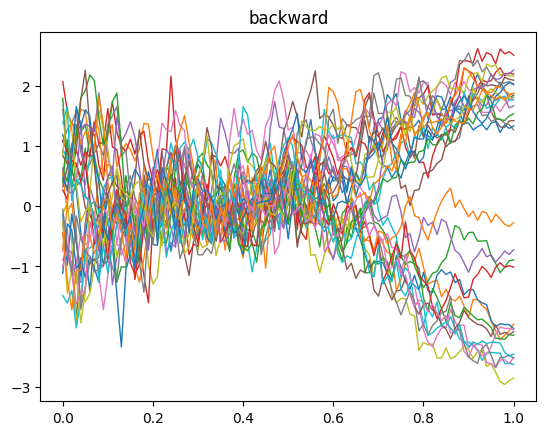

In [8]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using reconstruction loss. It doesn't give a good result. Can find a better loss to replace reconstrcton loss. After I find a better loss, combining PCF loss with another better loss should bring better and more stable results. 

In [ ]:
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

pcf = PCF_with_empirical_measure(16, 12, 1)
pcf = pcf.to(device)

num_epochs = 200
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_gen1, traj_back1 = diffusion.backward_sample(traj_forward[:,-1].unsqueeze(1).to(device), score_net) 
    traj_back_flip1 = torch.fliplr(traj_back1)
    loss = (torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_back_flip1.shape[0], -1), dim=(0,1)))
    loss.backward()
    opt.step()
    print(i, loss)

0 tensor(3.5815, device='cuda:0', grad_fn=<MeanBackward1>)
1 tensor(3.5688, device='cuda:0', grad_fn=<MeanBackward1>)
2 tensor(2.9778, device='cuda:0', grad_fn=<MeanBackward1>)
3 tensor(2.4023, device='cuda:0', grad_fn=<MeanBackward1>)
4 tensor(2.1398, device='cuda:0', grad_fn=<MeanBackward1>)
5 tensor(2.0433, device='cuda:0', grad_fn=<MeanBackward1>)
6 tensor(1.9749, device='cuda:0', grad_fn=<MeanBackward1>)
7 tensor(2.2298, device='cuda:0', grad_fn=<MeanBackward1>)
8 tensor(2.2338, device='cuda:0', grad_fn=<MeanBackward1>)
9 tensor(2.4067, device='cuda:0', grad_fn=<MeanBackward1>)
10 tensor(2.4999, device='cuda:0', grad_fn=<MeanBackward1>)
11 tensor(2.3914, device='cuda:0', grad_fn=<MeanBackward1>)
12 tensor(2.1538, device='cuda:0', grad_fn=<MeanBackward1>)
13 tensor(2.5826, device='cuda:0', grad_fn=<MeanBackward1>)
14 tensor(2.0554, device='cuda:0', grad_fn=<MeanBackward1>)
15 tensor(2.0613, device='cuda:0', grad_fn=<MeanBackward1>)
16 tensor(2.2246, device='cuda:0', grad_fn=<MeanBa

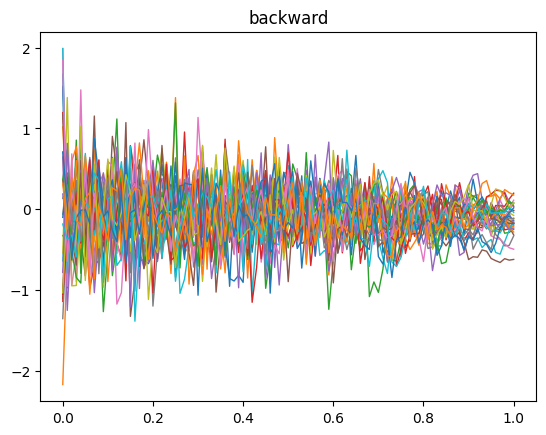

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using PCF loss. 

(So far I don't get a good result.) 



In [1]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
#device = 'mps'
device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


In [2]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

pcf = PCF_with_empirical_measure(16, 10, 1, add_time=True)
pcf = pcf.to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-3)

In [3]:
num_epochs = 800
for i in range(num_epochs):
    if 300<i <=600:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=5e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-4)
    elif i>600:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)

    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
        traj_forward_flip = torch.fliplr(traj_forward)
    pcf.train()
    D_loss = -pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), traj_back.view([-1, total_steps+1, 1]),Lambda=0.0)

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
   
    # train the score network to minmise the distance between the real data and the generated data
    x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
    pcf.eval()
    G_loss =  (pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), traj_back.view([-1, total_steps+1, 1]), Lambda=0.0))
           
    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()

    print(i, D_loss.item() , G_loss.item())

0 -2.429759979248047 2.5913896560668945
1 -2.463733434677124 2.4275269508361816
2 -2.4199233055114746 2.659252643585205
3 -2.7787396907806396 2.5904579162597656
4 -2.1686151027679443 2.3829076290130615
5 -1.6097978353500366 1.7834110260009766
6 -1.68239164352417 1.2426557540893555
7 -1.5366923809051514 1.2256031036376953
8 -2.28702974319458 2.135436534881592
9 -1.3267431259155273 1.6497670412063599
10 -1.8483411073684692 1.4854111671447754
11 -1.7878780364990234 1.9707190990447998
12 -1.596308946609497 2.1185569763183594
13 -2.6359214782714844 2.704951047897339
14 -1.6742377281188965 2.0737061500549316
15 -3.127871036529541 1.6794624328613281
16 -2.481254816055298 2.7568557262420654
17 -2.0196120738983154 1.302469253540039
18 -2.970351457595825 3.129304885864258
19 -1.615290880203247 2.8081865310668945
20 -1.687838077545166 1.8663427829742432
21 -1.4028925895690918 1.1060564517974854
22 -1.4572856426239014 2.0609145164489746
23 -2.6978816986083984 1.6595810651779175
24 -2.6532220840454

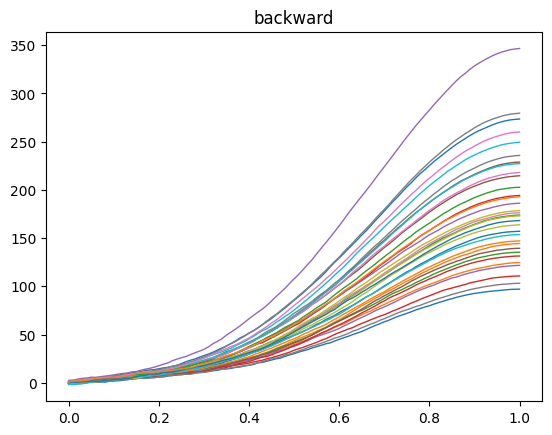

In [5]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')